# The Process Model Class and Multi Stage Optimization

After having successfuly identified dynamical models of the different phases of the injection moulding process, the goal is to use these models for optimal control during machine operation. For this purpose this Toolbox provides a class and a function, which allows the user to do so without having to formulate the optimization problem themselves.

## The ProcessModel() Class

The ProcessModel Class is a container which allows the user to
- store the identified models for the different phases (injection, packing, cooling) of the injection molding process as subsystem-models
- and parameterize the reference signals according to the needs of the user.

An instance of the ProcessModel Class can be passed to different functions in order to
- optimize the parameters of the reference signals in order to achieve a certain target trajectory or
- update the parameters of the subsystem-models given new measurement data.

In this tutorial, an instance of the ProcessModel Class will be used for the first purpose, i.e. Multi Stage Optimization.

### Subsystems

It is assumed, that models for the different phases of the injection molding process have already been identified and validated. Any class from the model-structures module can be used as a subsystem in the ProcessModel Class. Even user-specified classes are possible, as long as the model equations are formulated as a casadi.Function() and it possesses a OneStepPrediction and Simulation method. For the purpose of this tutorial, instead of identifying models from data, they will be manually specified: 

In [9]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

import sys

sys.path.append('C:/Users/LocalAdmin/Documents/GitHub/DigitalTwinInjectionMolding/')

from DIM.models import injection_molding, model_structures
from DIM.optim.control_optim import MultiStageOptimization

In [10]:
dt = 1

injection_model = model_structures.SecondOrderSystem(dt,'injection_model')
injection_model.Parameters={'A':np.array([[0,1],[-1,-1]]),'b':np.array([[0],[1]]),'c':np.array([[1,0]])}

packing_model = model_structures.FirstOrderSystem(dt,'packing_model')
packing_model.Parameters={'a':-0.1,'b':0.5}

cooling_model = model_structures.FirstOrderSystem(dt,'cooling_model')
cooling_model.Parameters={'a':-0.6,'b':0}

The First and Second-Order Systems were implemented as continuous-time equations which are integrated using a Runge-Kutta method, which is why a sampling time needs to be specified in this case. Notice also, that the parameter $b$ of the cooling model is equal to zero. Now, these models need to be passed to an instance of the ProcessModel Class. This is simply done, by passing them as a list to the subsystems attribute:

In [11]:
ProcessModel = injection_molding.ProcessModel()
ProcessModel.subsystems = [injection_model,packing_model,cooling_model]

### Reference Trajectories

In the following step, the reference signals need to be parameterized. This is necessary, because injection molding machines do not permit the specification of arbitrary reference signals. Usually these are designated to be step signals with two or three levels. The ProcessModel class expects the parameterized reference signals to be lambda functions with two arguments, the first beeing a dictionary containing the parameters, the second being the discrete time $k$. Furthermore, using truly discrete reference signals would result in an optimization problems with discrete variables. In order to circumvent this problem, the step signals are approximated via logistic functions with soft rather than hard transitions.

If, for example the reference signal in the filling phase is a step signal with three levels and the reference signal in the holding phase is a step signal with two levels appropriate functions could be   

In [12]:
W1 = lambda p,k: p['h1']+(p['h2']-p['h1'])/(1+np.exp(-2*(k-p['T1']))) + p['h2']+(p['h3']-p['h2'])/(1+np.exp(-2*(k-p['T2'])))
W2 = lambda p,k: p['h4']+(p['h5']-p['h4'])/(1+np.exp(-2*(k-p['T3'])))

To visualize these signals one has to provide a dictionary with parameters and a discrete time vector 

In [13]:
params = {'h1':np.array([[0]]),
          'h2':np.array([[5]]),
          'h3':np.array([[3]]),
          'T1':np.array([[10]]),
          'T2':np.array([[40]]),
          'h4':np.array([[6]]),
          'h5':np.array([[1]]),
          'T3':np.array([[80]])}

discrete_time = np.arange(0,150,1)

It is important, that the keys of the parameter dictionary exactly match the keys used in the lambda functions, otherwise the optimizer won't be able to find them.

The lambda functions can then be evaluated by passing the parameter dictionary and the discrete time vector.

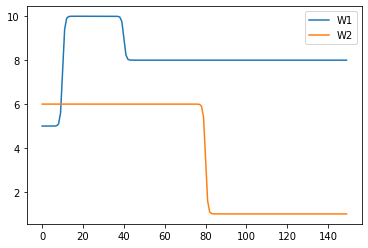

In [14]:
plt.plot(W1(params,discrete_time).T,label='W1')
plt.plot(W2(params,discrete_time).T,label='W2')
plt.legend()

The lambda functions need to be passed to the reference-attribute of the ProcessModel instance as a list in order for the optimization procedures to recognize them as the optimization target. The order must match the order of the subsystems.

In [15]:
ProcessModel.reference = [[W1],[W2],[]]

The dictionary which contains initial estimates for the parameters of the reference trajectories must also be passed to the ProcessModel via the attribute ref_params

In [16]:
ProcessModel.ref_params = params

Finally, the switching instances, i.e. when the transition from one subsystem to the next, must be provided as a list of integers. Usually, these switching instances are not known and are also part of the optimization problem. This will be covered in another tutorial. For the sake of this tutorial, it is assumed, that the switching instances are known and fixed:  

In [17]:
ProcessModel.switching_instances = [80,120]

## The MultiStageOptimization() function

Given an instance of the ProcessModel() Class and a target trajectory, the MultiStageOptimization() procedure optimizes the parameters of the reference trajectories, such that the mean squared error between the output predicted by the instance of ProcessModel() and the target trajectory is minimized.

Usually, the target trajectory is the result of expertise (e.g. the trajectory of the cavity pressure in an injection molding process can be derived from the pvT diagram) or itself the result of an optimization problem. In this tutorial the reference trajectory will just be an arbitrary signal:

In [ ]:
N=150

target = np.zeros((N,1))
target[0:20]=2
target[20:40]=6
target[40:80]=4
target[80:100]=4
target[100:120]=2
target[120:150]=0

plt.plot(target,label='target')

In [ ]:
result = MultiStageOptimization(ProcessModel,target)

MultiStageOptimization() returns a dictionary with the optimized parameters and the resulting output trajectory. The optimized output trajectory can be compared to the target trajectory

In [ ]:
plt.plot(target,label='target')
plt.plot(np.array(result['X']),label='opt. output')
plt.legend()

and the corresponding trajectories of the reference signals can be calculated by passing the result dictionary to the lambda functions

In [ ]:
W1_opt = W1(result,np.arange(1,150,1))
W2_opt = W2(result,np.arange(1,150,1))

plt.plot(W1_opt.T,label='W1_opt')
plt.plot(W2_opt.T,label='W2_opt')
plt.legend()